---

<p align="center">
  <img src="https://raw.githubusercontent.com/lacamposm/Diplomado_Metodos_UCentral/main/data/images/imagen_ucentral.jpg" alt="logo_Ucentral" width="400px" height="300px">
</p>

In [1]:
%%capture
!pip install pingouin ## instalación libreria pingouin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, nct   ## distribuciones t y t no-central.
from pingouin import ttest       ## ttest: prueba-t
##
sns.set_style("darkgrid")
##
url_base= "https://raw.githubusercontent.com/lacamposm/Fundamentos_Analitica/main/data/"

---
# ***Estudio sobre el crecimiento de los árboles en un bosque de California***
---


## ***Objetivos***

Problemas claves en el análisis de información es lograr determinar si un patrón que se observa es lo suficientemente significativo como para justificar una mayor investigación. Una herramienta fundamental para abordar este problema es llamada **prueba de hipótesis estadística**. 

Deseamos dejar interiorizado:

* Comprensión de las distribuciones de muestreo y la significación estadística.
* Realizar pruebas de hipótesis y hacer inferencias.


## ***Introducción***

**Contexto comercial.** Usted es parte de una organización de la sociedad civil que realiza un seguimiento de las métricas ambientales relacionadas con la deforestación y la calidad de los bosques en los Estados Unidos. El equipo de análisis de datos tiene la tarea de realizar una evaluación de las posibles estrategias de conservación para un bosque protegido en el estado de California. Como parte del proyecto de investigación, necesitan establecer algunas métricas descriptivas de la estratificación vertical del bosque (qué especies de árboles pertenecen al dosel y cuáles al sotobosque), diversidad de especies, biomasa, etc. Esto es importante porque si los árboles en este lugar específico exhibe características físicas diferentes a las de los árboles en el resto de California, es posible que sea necesario ajustar las estrategias para conservarlos para tener en cuenta estas particularidades.

**Problema comercial.** Su trabajo es **determinar qué especies de árboles en el bosque protegido tienen alturas que difieren sustancialmente de las alturas promedio de esas especies en todo el estado de California.** A partir de esto, otros miembros del equipo procederán realizar estudios específicos de especies para investigar más a fondo las condiciones ecológicas de los lugares donde se encuentran estos árboles.

**Contexto analítico.** Se le proporcionó un conjunto de datos de la encuesta que contiene datos de 18 especies del bosque protegido. La muestra contiene 100 árboles por especie. 

La tabla con la que estaremos trabajando tiene las siguientes features:

1. **CN**: un identificador de árbol único. Cada árbol en la encuesta tiene un número.
2. **HT**: Altura del árbol en pies.
3. **SITREE**: El [índice del sitio](https://en.wikipedia.org/wiki/Site_index) (altura normalizada por edad del árbol en pies)
4. **common_name**: el nombre común de la especie arbórea.
5. **scientific_name**: el nombre científico de la especie arbórea.

## ***Distribuciones de muestreo.***

En la reserva hay 390.955 árboles de los que disponemos de datos censales. La altura media de todos esos árboles es de 57,35 pies (17,5 metros). Por lo tanto, decimos que la **población** consta de 390.955 árboles, y que la **media poblacional** de la altura de los árboles es de 57,35 pies (es decir, la media de la altura de todos los árboles de la población es de 57,35 pies). Denotaremos la media de la población como la letra griega $\mu$.


In [3]:
censo = pd.read_csv(url_base + "censo.csv", names=["ID","CN", "HT"], header=0, 
                    usecols=["CN","HT"])
display(censo.head())
print("\nTamaño de la población:", censo.shape[0])

,CN,HT
0,248587121489998,35.0
1,8888777010901,37.0
2,449560175489998,51.0
3,449558216489998,45.0
4,23220187010497,39.0



Tamaño de la población: 390955


In [4]:
censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390955 entries, 0 to 390954
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CN      390955 non-null  int64  
 1   HT      357186 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 6.0 MB


In [5]:
media, std = censo['HT'].mean(), censo['HT'].std()
string = "La media y desviación poblacional son respectivamente: {:.2f} pies y {:.2f} pies."
print(string.format(media,std))

La media y desviación poblacional son respectivamente: 57.35 pies y 39.62 pies.


***Aquí está la distribución de las alturas de los árboles en la población, con $\mu=57.35$ representado como una línea vertical en rojo:***


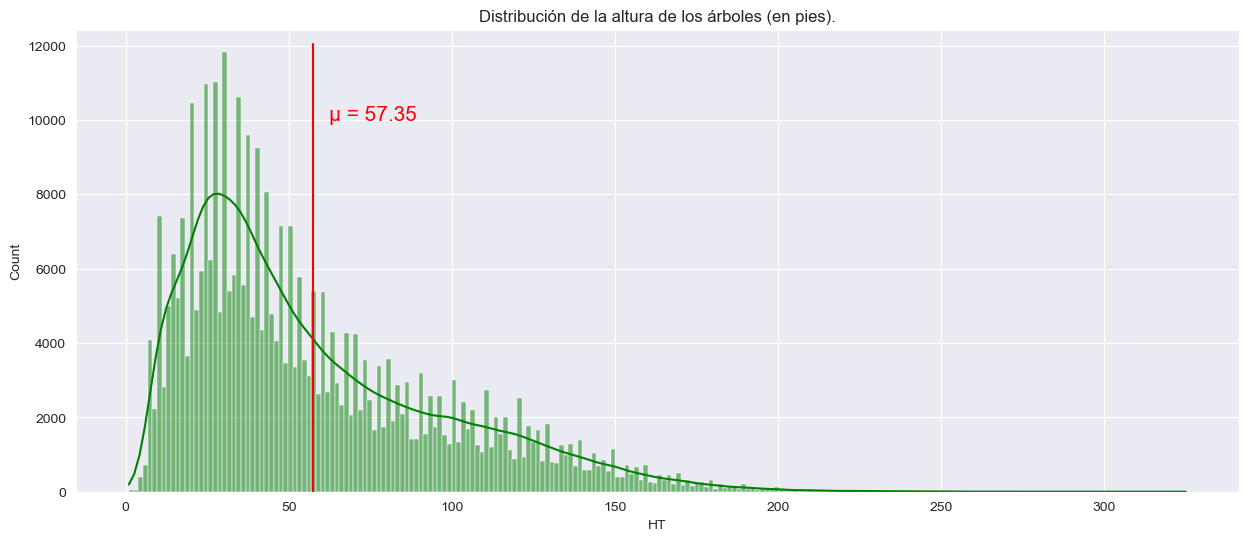

In [6]:
media = censo['HT'].mean()
##
plt.figure(figsize = (15,6))
sns.histplot(data = censo, x = "HT", kde = True, color = "green")
plt.axvline(x = media, ymin = 0, ymax = 0.97, color = "red")
plt.text(media+5,10000,"\u03BC = {:.2f}".format(media), fontsize = 15, color = "red")
plt.title("Distribución de la altura de los árboles (en pies).")
plt.show()

En muchos escenarios del mundo real, no tenemos acceso a toda la población de datos, en cambio, tenemos muestras. Esto crea incertidumbre porque es muy poco probable que la media de una muestra determinada sea exactamente igual a la media de la población de la que se extrae, incluso si la muestra es grande y se tomó al azar.

Debido a esto, vamos a analizar las **distribuciones muestrales**. La distribución muestral de la media muestral debe construirse utilizando muchos valores. La distribución muestral de la media muestral es la distribución de las medias de muchas muestras extraídas al azar de la población.

Por ejemplo, sabemos que la reserva tiene 390.955 árboles y que $\mu=57,5$. Podemos tomar muestras de 20 árboles a la vez y calcular sus medias muestrales así:

In [7]:
censo["HT"].sample(20)

183018     15.0
205659     34.0
148012      NaN
352013     29.0
291008     10.0
172558     67.0
352589     64.0
266058     27.0
329403     92.0
115378     39.0
272216    130.0
373522     38.0
325822    153.0
307272     70.0
171463     27.0
10461     163.0
118430     62.0
97729      16.0
242255     72.0
310631     79.0
Name: HT, dtype: float64

In [8]:
np.random.seed(1) ## Semilla para replicar los resultados.
a = {"Muestra {}".format(i+1):censo["HT"].sample(20).mean() for i in range(10)}
pd.DataFrame.from_dict(a,orient='index', columns = ["Media"]).T

,Muestra 1,Muestra 2,Muestra 3,Muestra 4,Muestra 5,Muestra 6,Muestra 7,Muestra 8,Muestra 9,Muestra 10
Media,64.411765,49.944444,54.352941,61.666667,49.117647,60.473684,79.368421,48.315789,47.052632,50.631579


Podemos crear una tabla de frecuencia con todas estas medias muestrales y eso constituiría ***nuestra distribución muestral de la media muestral***. Como vemos, estas medias de muestra están bastante cerca de $\mu$, pero ninguna es exactamente igual a $\mu$. Esta variación se debe al hecho de que nuestro tamaño de muestra es más pequeño que el tamaño de la población. Sin embargo, aún podemos obtener una muy buena estimación de $\mu$ al estudiar la ***distribución muestral de la media muestral.***

#### ***Ejercicio 1.***

 
La función de la celda de abajo muestra la distribución  muestral de la media muestral para diferentes tamaños de muestra $n$ en nuestro conjunto de datos del censo de la reserva. Cambie los valores de los parámetros. Por ejemplo, si establece $n=50$ y el número de muestras en $m=100$, entonces la función tomará 100 muestras de 50 árboles cada una de la población, encontrará la media de cada muestra y trazará la distribución muestral de todas las medias muestrales.

A partir de esto, calculamos la media de la distribución muestral y la imprimimos en azul. También damos como referencia la media poblacional (la sabemos del censo) en color rojo.

Experimente con diferentes valores de $n$ y de $m$ (número de muestras). ¿Qué observa acerca de la relación entre la media de la distribución muestral y la media de la población?

In [9]:
def plot_media_muestral(df_Serie,n=1,m=1):
    '''
    Input:  df_serie =  Serie de Pandas con la columna a muestrear.
            n = Tamaño de la muestra.
            m = número de muestras.
    Output: Plot con la media poblacional (recta roja), distribución de muestreo y la media 
            muestral (recta vertical azul).    
    '''
    mean_population = df_Serie.mean()
    info = [df_Serie.sample(n).mean() for i in range(m)]
    mean_sample = sum(info)/len(info)
    plt.figure(figsize=(15,6))
    sns.histplot(x = info, kde = True, color = "green",stat = "density", bins = 20)
    plt.axvline(x = mean_population, color = "red")
    plt.axvline(x = mean_sample)
    plt.text(mean_population+0.5,0.01,"\u03BC = {:.2f}".format(mean_population), 
             fontsize = 15, color = "red")
    plt.text(mean_sample-3,0.02,"media muestral= {:.2f}".format(mean_sample),
             fontsize = 15, color = "blue")
    plt.title(f'Muestras de tamaño {n}. Total de muestras {m}', fontsize = 22, 
              fontstyle = "italic")
    plt.xlim(20,100)
    plt.show()
    return None

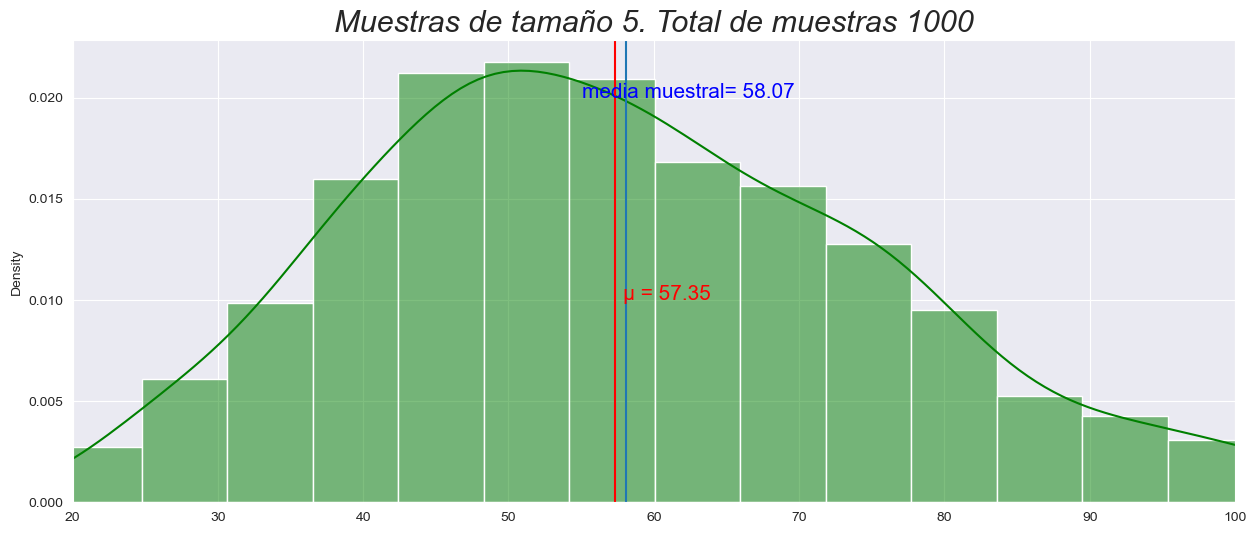

In [10]:
## 1000 muestras de tamaño n = 5
plot_media_muestral(censo['HT'],5,1000)

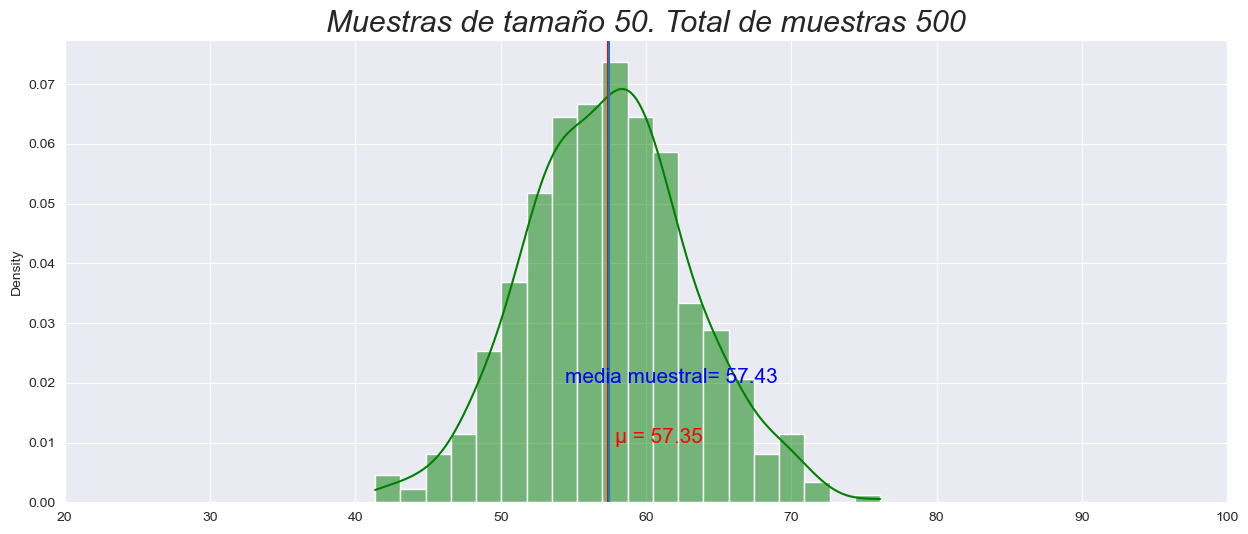

In [11]:
## 500 muestras de tamaño n = 50
plot_media_muestral(censo['HT'],50,500)

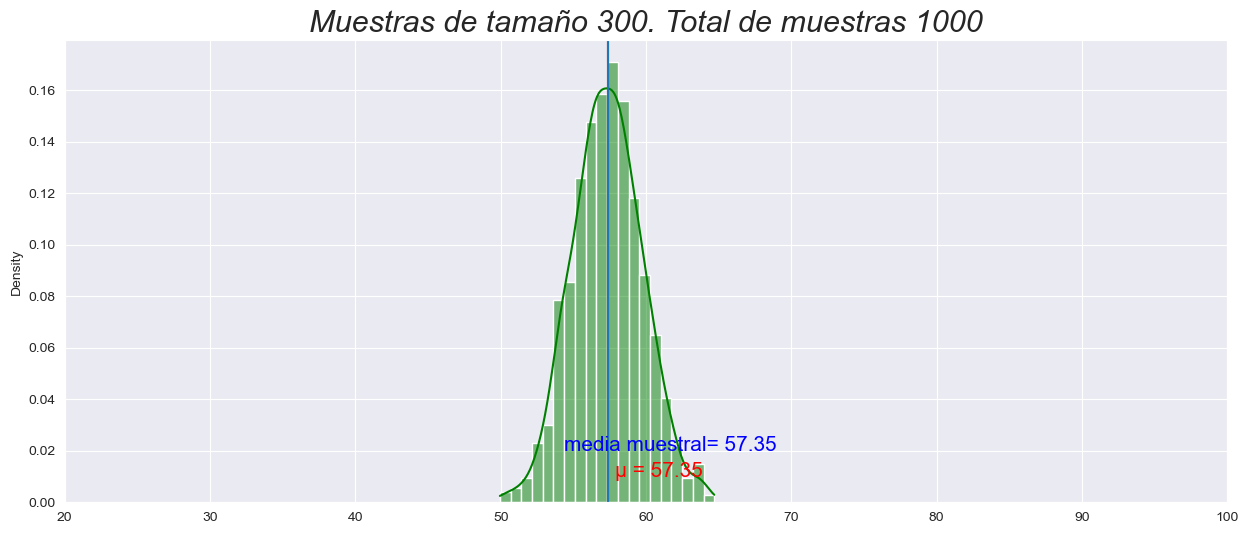

In [12]:
## 1000 muestras de tamaño n = 300
plot_media_muestral(censo['HT'],300,1000)

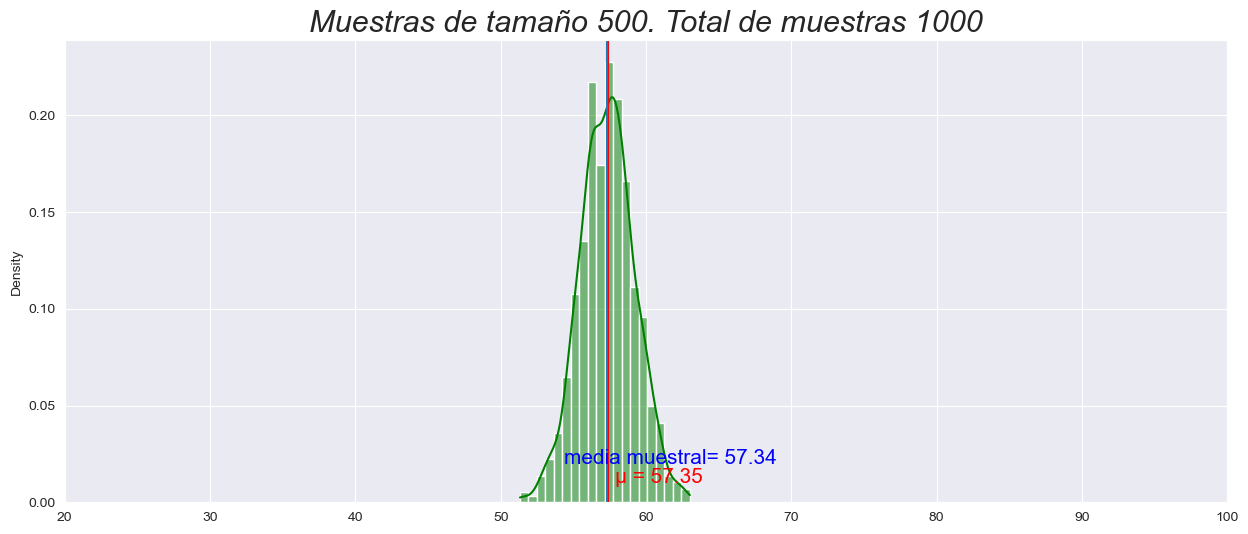

In [13]:
## 1000 muestras de tamaño n = 5
plot_media_muestral(censo['HT'],500,1000)

***Respuesta.*** Debe haber observado alguno (o todos) de las siguientes comentarios.

1. Con muchas muestras, la media de las medias muestrales convergerá a $\mu$. Esto será cierto incluso si los tamaños de muestra en sí son pequeños. (Ley de los grandes número)

2. La dispersión de la distribución depende del tamaño de la muestra. Cuanto menor sea el tamaño de la muestra, más amplia será la distribución. (Pensar en el TLC)

3. A medida que aumenta el tamaño de la muestra, suponiendo un gran número de muestras, la distribución muestral de la media muestral comienza a tener forma de campana (Teorema del límite central).

---
### ***$p$-valores.*** <font/>
---


Otro concepto importante que necesitaremos para responder a la pregunta de investigación es el de los **$p$-valores**. Un $p$-valor indica la probabilidad de que obtenga un número determinado o mayor cuando toma una muestra al azar de un distribución dada.

#### ***Ejercicio 2.***

#### ***2.1***

Supongamos que tenemos dos medias muestrales $A$ y $B$ como se muestra a continuación:

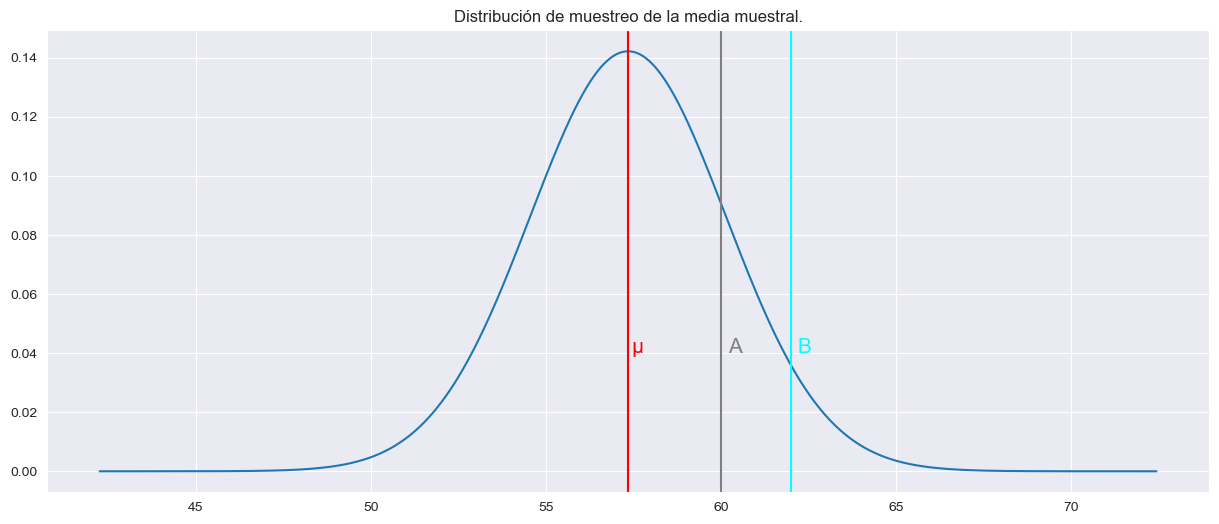

In [14]:
mu, S, df, nc = censo["HT"].mean(), censo["HT"].std(), 199, 0 ## Media, desviación estandar, df.
se = S/np.sqrt(200)                                           ## Error estandar.
x = np.linspace(nct.ppf(0.0000001, 199, 0, loc=mu, scale=se),
                nct.ppf(0.9999999, 199, 0, loc=mu, scale=se), 1000)
pdf = nct.pdf(x, 199, 0, loc = mu, scale = se)
## 
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
plt.axvline(x = censo['HT'].mean(), color = "red")
plt.axvline(x = 60, color = "grey")
plt.axvline(x = 62, color = "cyan")
plt.text(60.2,0.04,"A", fontsize = 15, color = "grey")
plt.text(62.2,0.04,"B", fontsize = 15, color = "cyan")
plt.text(mu+0.1,0.04,"\u03BC", fontsize = 15, color = "red")
plt.title("Distribución de muestreo de la media muestral.")
plt.show()


¿Es más probable observar $A$ o un valor mayor, o $B$ o un valor mayor, dada nuestra distribución de muestreo?

***Respuesta.*** $A$ o que sea mayor es más probable. Vea que $A$ tiene una mayor densidad de probabilidad a su alrededor y, además, su $p$-valor es mayor que el de $B$. Podemos decir que la media muestral $B$ es *más extrema* que la media muestral $A$, lo que hace que los valores $x_{i}\geq B$ sean menos probables de observar bajo la distribución muestral.

#### ***2.2***

Ahora compare la media muestral $B$ con una tercera media muestral $C$. ¿Es plausible observar $C$ como media muestral? ¿Puede decir algo sobre la población de la que se tomó la muestra $C$?

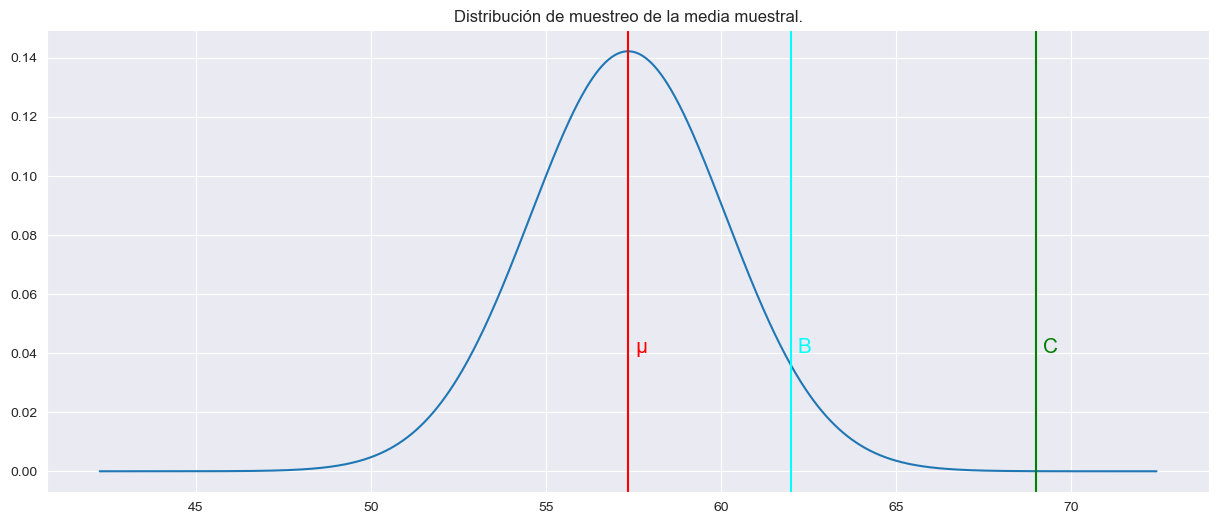

In [15]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
plt.axvline(x = mu, color = "red")
plt.axvline(x = 62, color = "cyan")
plt.axvline(x = 69, color = "green")
plt.text(62.2,0.04,"B", fontsize = 15, color = "cyan")
plt.text(69.2,0.04,"C", fontsize = 15, color = "green")
plt.text(mu+0.2,0.04,"\u03BC", fontsize = 15, color = "red")
plt.title("Distribución de muestreo de la media muestral.")
plt.show()

**Respuesta.** La muestra $C$ tiene *alguna* probabilidad de ser de la misma población que la nuestra; sin embargo, esta probabilidad es muy baja. Esto podría interpretarse como una sugerencia de que $C$ en realidad proviene de una población diferente.

En otras palabras, cuanto más lejos esté la media de una muestra de $\mu$, *menos* probable es que la población de la que se tomó tenga una media poblacional de $\mu$.

---

### ***Pruebas de hipótesis.*** 

---

Que dos valores sean estadísticamente iguales es diferente a decir que son aritméticamente iguales. Supongamos que $\bar{X}=56 \text{ pies}$, sabemos que $\mu=57.35 \text{ ft}$. Claramente, esos dos son números muy diferentes, por lo que no son aritméticamente iguales. Sin embargo, podemos argumentar razonablemente que la muestra a partir de la cual se calculó $\bar{X}$ *provino de hecho de una población con una media de $\mu_1=\mu$*, y que la diferencia de $1,35 \text{ft}$ se debió al hecho de que solo observamos una muestra, en lugar de toda la población. En otras palabras, el argumento es así:

> "Hay una diferencia entre $\bar{X}$ y $\mu$, pero si aumenta el tamaño de su muestra para que sea toda la población, probablemente encontrará que $\bar{X}= \mu_1=\mu=57,35$. Esperamos que la diferencia entre $\bar{X}$ y $\mu$ se reduzca a cero a medida que aumentamos el tamaño de la muestra. Por lo tanto, ajustada por la variabilidad normal del muestreo, la diferencia entre $\bar{\mu_1}$ (estimado por $\bar{X}$) y $\mu$ no es **estadísticamente significativa.**"

Podemos usar **pruebas de hipótesis** para determinar si la diferencia entre $\mu$ y la media $\mu_1$ de la población de la que se tomó la media muestral $\bar{X}$ es estadísticamente significativa. Una **hipótesis** es simplemente una suposición informada que hacen los analistas de datos, y esta suposición puede o no tener evidencia que la respalde. Probamos nuestra conjetura reuniendo evidencia a favor o en contra, y evaluamos la solidez de esa evidencia para determinar la validez de nuestra hipótesis.

El primer paso en la prueba de hipótesis es definir la **hipótesis nula** (frecuentemente denotada como $H_0$). Para nosotros, la hipótesis nula siempre corresponderá a la afirmación más conservadora. Muchas veces, esta hipótesis conservadora será $ H_0: \mu_1=\mu$.

### ***La hipótesis alternativa.***

Realizamos pruebas de hipótesis para desafiar nuestras afirmaciones (hipótesis), usamos métodos conservadores para asegurarnos de no rechazarlas con demasiada facilidad. En ese sentido, la ciencia limita su velocidad de innovación para reducir el riesgo de llegar a resultados demasiado audaces y arriesgados. Una buena analogía es el principio que rige numerosos sistemas judiciales en todo el mundo: _"[Inocente hasta que se pruebe su culpabilidad](https://en.wikipedia.org/wiki/Presumption_of_innocence)"_. En otras palabras, mantendremos la hipótesis nula a menos que encontremos pruebas sólidas en su contra.

Note que este enfoque, como es el caso con el sistema judicial, no es perfecto. Incluso si no encontramos suficiente evidencia en contra de la hipótesis nula, la hipótesis nula aún puede resultar incorrecta.

Para formalizar esto, definimos una **hipótesis alternativa** (a menudo indicada con $H_1$ o $H_a$) que desafía la hipótesis consevadora. Hay tres formas diferentes de definir una hipótesis alternativa:

1. $H_a: \mu_1\neq \mu$ (prueba bilateral)

2. $H_a: \mu_1 < \mu$ (prueba unilateral)

3. $H_a: \mu_1 > \mu$ (prueba unilateral)

Definamos nuestra hipótesis alternativa como $H_a: \mu_1 > \mu$ (la tercera opción) por ahora (veremos las otras más adelante). Cuestionamos la suposición de que las medias de las dos poblaciones son estadísticamente iguales y queremos demostrar que la media de la población *desconocida* de la que se tomó nuestra muestra es mayor que la media $\mu$ de la población *conocida*.

***Test de hipótesis***

$$ H_0: \mu_1=57.35$$
$$VS.$$
$$H_a: \mu_1 > 57.35$$

### ***Contexto***

1. Nosotros conocemos que la media poblacional es $\mu=57.35$.

2. ***TLC:*** Sea $X_1,X_2,X_3, \dots , X_n$ un conjunto de variables aleatorias independientes e identicamente distribuidas, cada una de ellas con función de distribución $F$, y supongamos que $E(X_k)=\mu$
y $Var(X_k)=\sigma^2$ 

  Si 

  $$\bar{X}=\frac{X_1+X_2+X_3+\dots X_n}{n}$$ 

  entonces 

  $$\bar{X} \longrightarrow N\left(\mu, \frac{\sigma^2}{n}\right)$$

3. Al tomar una muestra "grande" podemos hacer uso del ***TLC*** para pensar en la distribución muestral de la media muestral. **PROBLEMA:** En las situaciones reales no conocemos $\mu$ (valor esperado) ni $\sigma^{2}$ (varianza). 

4. Al realizar la prueba de hipótesis, suponemos que $H_0$ es verdadera, en cuyo caso ya no desconocemos a $\mu$, quien sigue siendo desconocido es $\sigma^{2}$.

5. El problema del desconocimiento de $\sigma^{2}$ se soluciona tomando a:

  $$T = \frac{\bar{X}-\mu}{S/\sqrt{n}} $$

  Quien distribuye $T\sim t_{n-1}$, donde $S$ es la desviación estandar de la muestra.

#### ***Ejercicio 3.***

Repasemos el diagrama del ejercicio anterior:



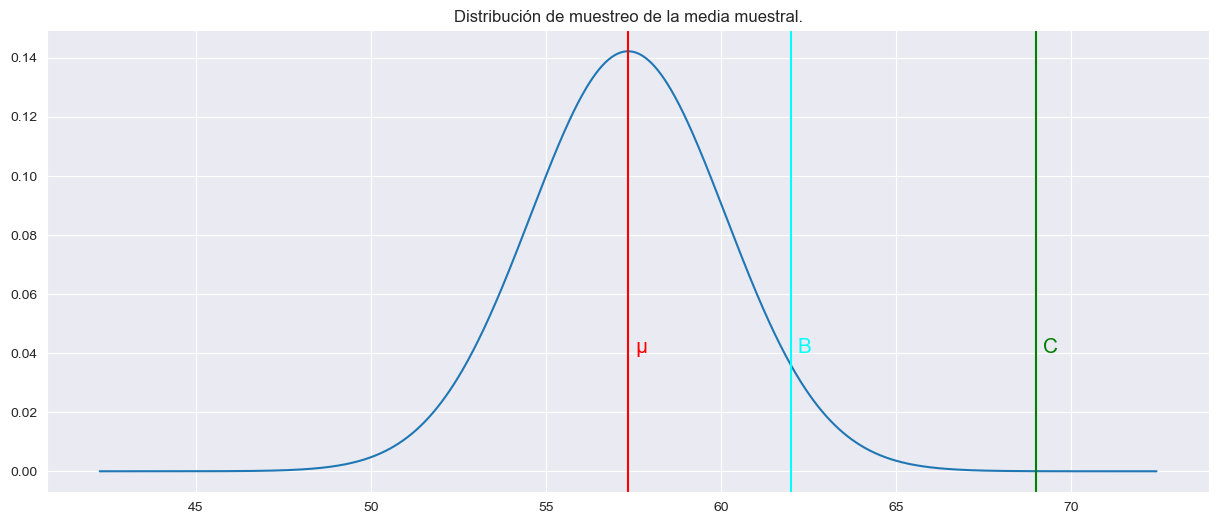

In [16]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
plt.axvline(x = mu, color = "red")
plt.axvline(x = 62, color = "cyan")
plt.axvline(x = 69, color = "green")
plt.text(62.2,0.04,"B", fontsize = 15, color = "cyan")
plt.text(69.2,0.04,"C", fontsize = 15, color = "green")
plt.text(mu+0.2,0.04,"\u03BC", fontsize = 15, color = "red")
plt.title("Distribución de muestreo de la media muestral.")
plt.show()

Supongamos que cree que la media de la población de la que se extrajo la media muestral $B$ es estadísticamente igual a $57.35$, mientras que la media de la población de la que se extrajo la media muestral $C$ no lo es. Quiere convencer que este es el caso. Piense en un criterio más objetivo para determinar si una media poblacional inferida es estadísticamente diferente de $57.35$ o no.

**Respuesta.** Una forma razonable de hacer que el proceso sea menos subjetivo (aunque no lo hace completamente objetivo) es definir un umbral en el eje $x$ más allá del cual los valores se considerarán significativamente diferentes de la media de la población.

---

## ***Valores críticos y niveles de significancia.*** <font/>

---


Podemos definir un punto de corte en nuestra distribución, de modo que siempre que la media de una muestra caiga más allá de ese punto, podemos decir con confianza que su media poblacional inferida es estadísticamente diferente de $\mu$. Estos puntos de corte se denominan **valores críticos**. Por ejemplo, digamos que nuestro valor crítico es 65 pies:

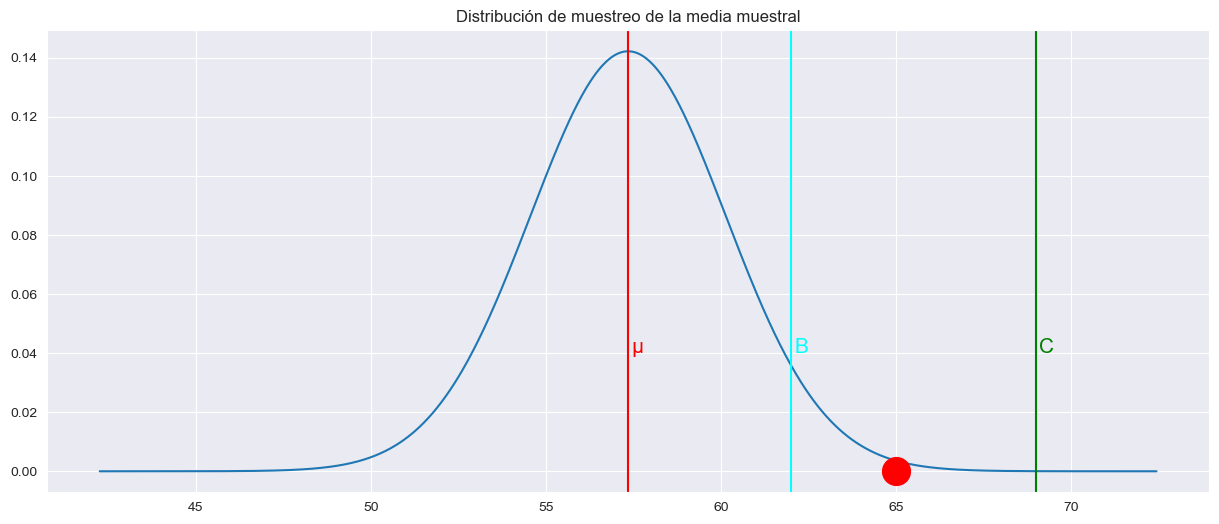

In [17]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
plt.axvline(x = censo['HT'].mean(), color = "red")
plt.axvline(x = 62, color = "cyan")
plt.axvline(x = 69, color = "green")
plt.text(62+0.1,0.04,"B", fontsize = 15, color = "cyan")
plt.text(69+0.1,0.04,"C", fontsize = 15, color = "green")
plt.text(mu+0.1,0.04,"\u03BC", fontsize = 15, color = "red")
plt.title("Distribución de muestreo de la media muestral")
plt.plot(65,0, marker="o", color="red",markersize = 20)
plt.show()

Por lo tanto:

* Como $B < 65$, decimos que la media poblacional inferida de $B$ *no* es estadísticamente diferente de $\mu$. No podemos probarlo, pero tampoco podemos refutarlo, y como estamos siendo conservadores, nos atenemos a la hipótesis nula (aunque no podemos decir que sea 100% correcta) y decimos que *no logramos rechazar la nula hipótesis*.

* Como $C > 65$, decimos que la media poblacional inferida de $C$ es estadísticamente diferente de $\mu$. En otras palabras, *rechazamos la hipótesis nula*. (Todavía hay alguna probabilidad de que $C$ no sea estadísticamente diferente de $\mu$, pero esa probabilidad en este caso es suficientemente pequeña).



El problema con los valores críticos es que tienen que ser redefinidos en cada situación o prueba de hipótesis. Por ejemplo, si nuestro conjunto de datos tuviera medidas del diámetro del tronco en pulgadas, entonces nuestro punto de corte tendría que ajustarse para que esté en pulgadas y toda la comunidad científica tendría que ponerse de acuerdo sobre qué valor crítico tendría más sentido: ¿4 pulgadas? ¿6 pulgadas? ¿1 pulgada?

La forma de resolver este problema es definir nuestros valores críticos indirectamente, usando algo llamado ***niveles de significancia***. Un nivel de significancia es simplemente el $p$-valor que corresponde a un valor crítico dado. Por ejemplo, en nuestra distribución (con $n=200$), el valor $p$ para el valor crítico a 65 pies es 0,003886. Para evitar confusiones entre el $p$-valor de la media de una muestra y el $p$-valor de un valor crítico, usamos la letra griega $\alpha$ para representar el nivel de significancia.

Luego, los científicos pueden ponerse de acuerdo sobre niveles de significancia razonables (que son independientes de la unidad, ya que son probabilidades) y dejar que los valores críticos se ajusten por sí solos en cada contexto individual. En las ciencias sociales, un nivel de significancia común es $\alpha=0.05$, y en las ciencias naturales, un estándar popular es $\alpha=0.01$.

#### ***Ejercicio 4.***

#### ***4.1***

Cambie los valores de $\alpha$ en la función de abajo. ¿Observa algo con la hipótesis a medida que cambia los valores de $\alpha$? 

Estas son las 2 hipótesis nulas (una para cada muestra):

* $H_0:\mu_B=57.35$
* $H_0: \mu_C=57.35$

Comente.

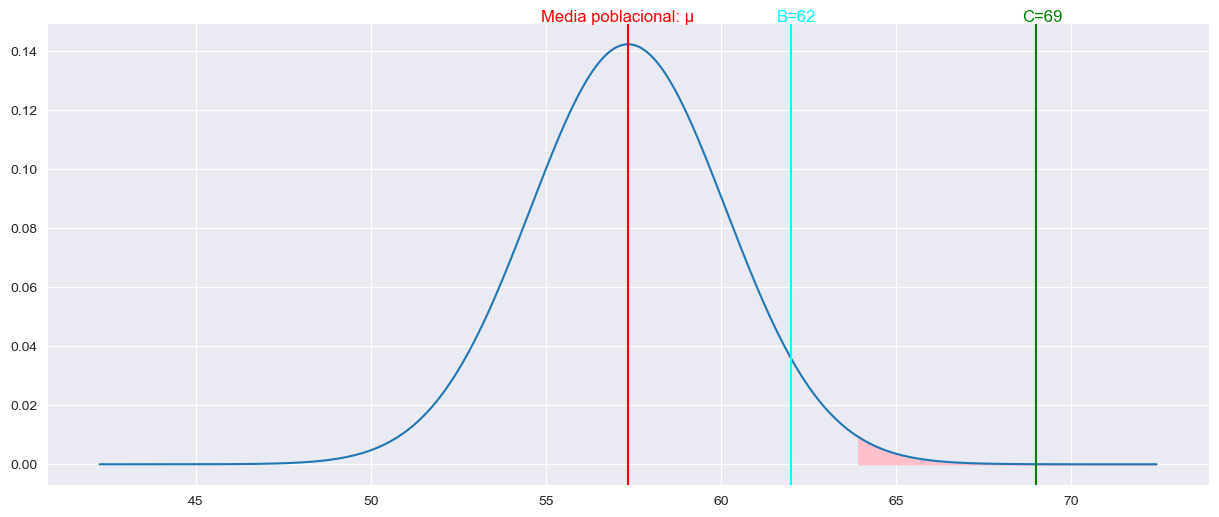

El valor crítico para α=0.01 es 63.920 pies
La hipótesis nula para la muestra B: NO RECHAZADA.
La hipótesis nula para la muestra C: RECHAZADA.


In [18]:
def p_valor_plot(alpha):
    plt.figure(figsize = (15,6))
    sns.lineplot(x = x, y = pdf)
    plt.axvline(x = mu, color = "red")
    plt.axvline(x = 62, color = "cyan")
    plt.axvline(x = 69, color = "green")
    plt.text(61.6,0.15,"B=62", fontsize = 12, color = "cyan")
    plt.text(68.6,0.15,"C=69", fontsize = 12, color = "green")
    plt.text(mu-2.5,0.15,"Media poblacional: \u03BC", fontsize = 12, color = "red")
    ##
    percentil = nct.ppf(1-alpha, 199, 0, loc = mu, scale = se)
    x_alpha = np.delete(x, np.where(x < percentil))
    plt.fill_between(x_alpha, nct.pdf(x_alpha, df, nc, loc=mu, scale=se), color="pink")
    plt.show()
    print(f'El valor crítico para \u03B1={alpha :.2f} es {percentil:.3f} pies' )
    if percentil < 62:
        print("La hipótesis nula para la muestra B: RECHAZADA.")
    else:
        print("La hipótesis nula para la muestra B: NO RECHAZADA.")
    if percentil < 69:
        print("La hipótesis nula para la muestra C: RECHAZADA.")
    else:
        print("La hipótesis nula para la muestra C: NO RECHAZADA.")
    return None

p_valor_plot(0.01)

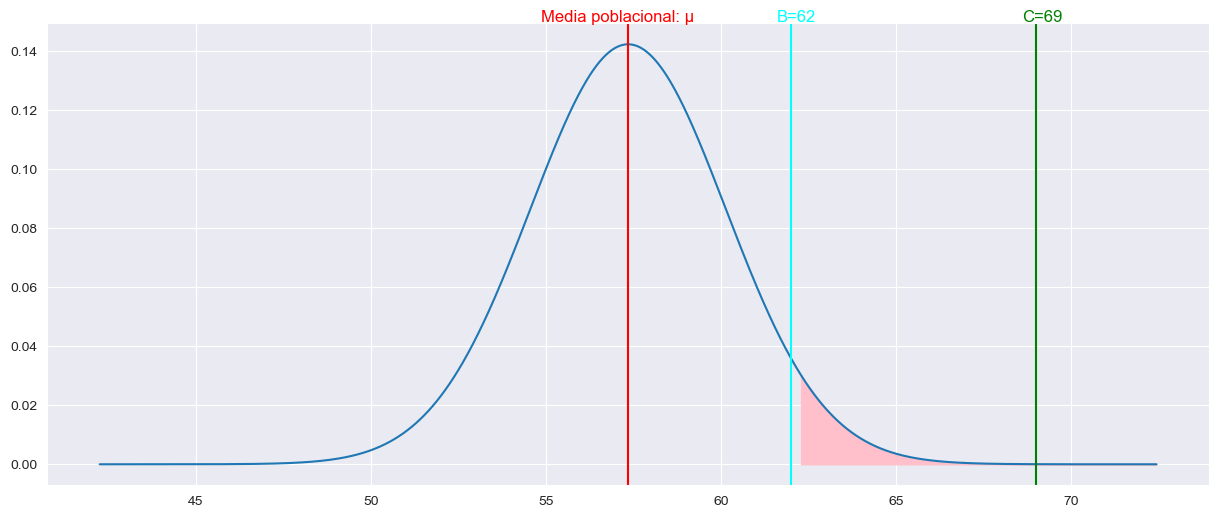

El valor crítico para α=0.04 es 62.279 pies
La hipótesis nula para la muestra B: NO RECHAZADA.
La hipótesis nula para la muestra C: RECHAZADA.


In [19]:
## Celda para probar
p_valor_plot(0.04)

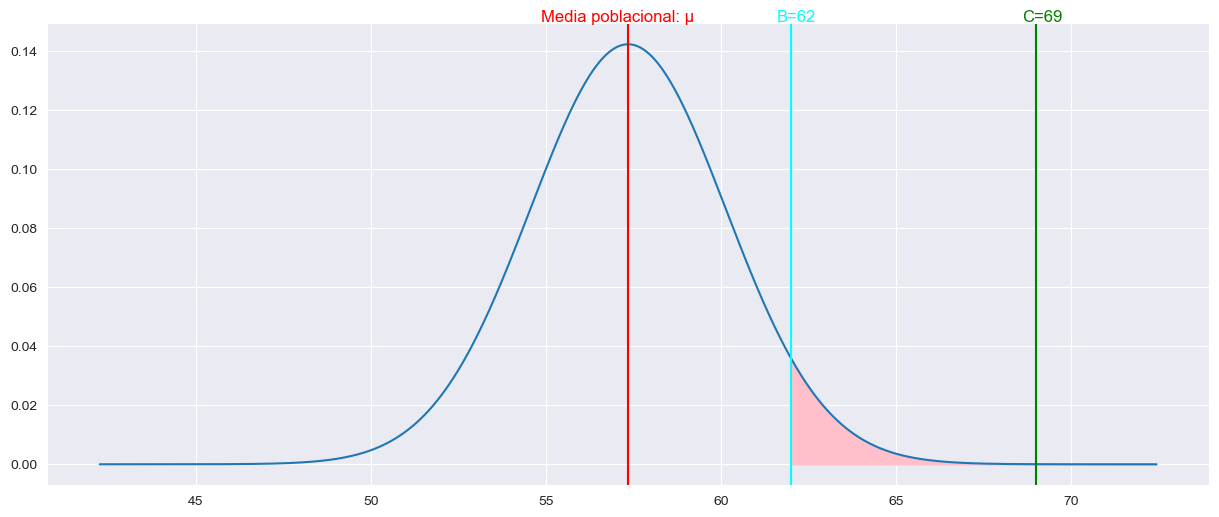

El valor crítico para α=0.05 es 61.979 pies
La hipótesis nula para la muestra B: RECHAZADA.
La hipótesis nula para la muestra C: RECHAZADA.


In [20]:
## Celda para probar
p_valor_plot(0.05)

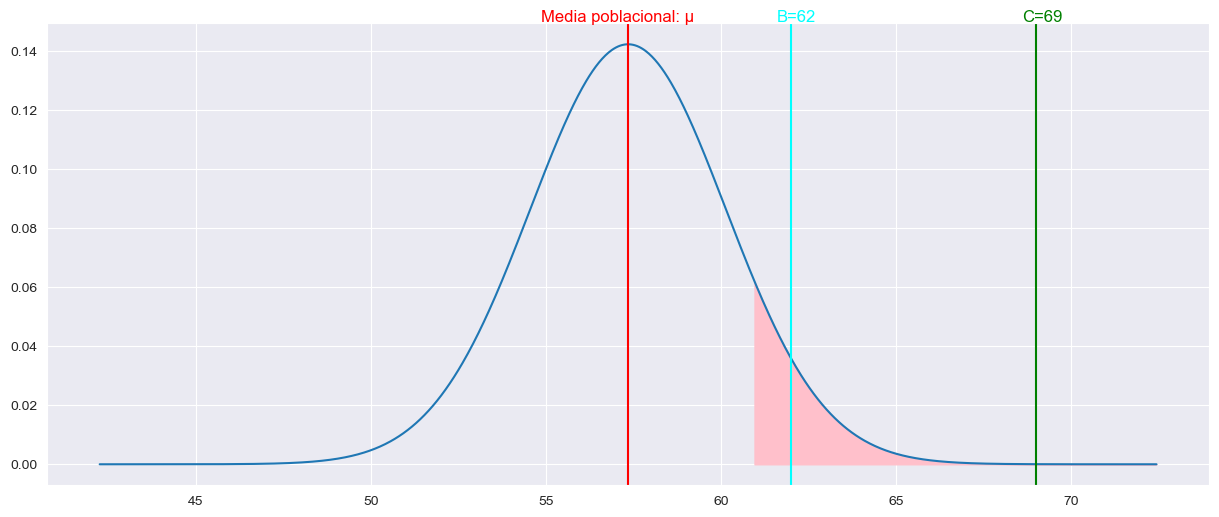

El valor crítico para α=0.10 es 60.951 pies
La hipótesis nula para la muestra B: RECHAZADA.
La hipótesis nula para la muestra C: RECHAZADA.


In [21]:
## Celda para probar
p_valor_plot(0.10)

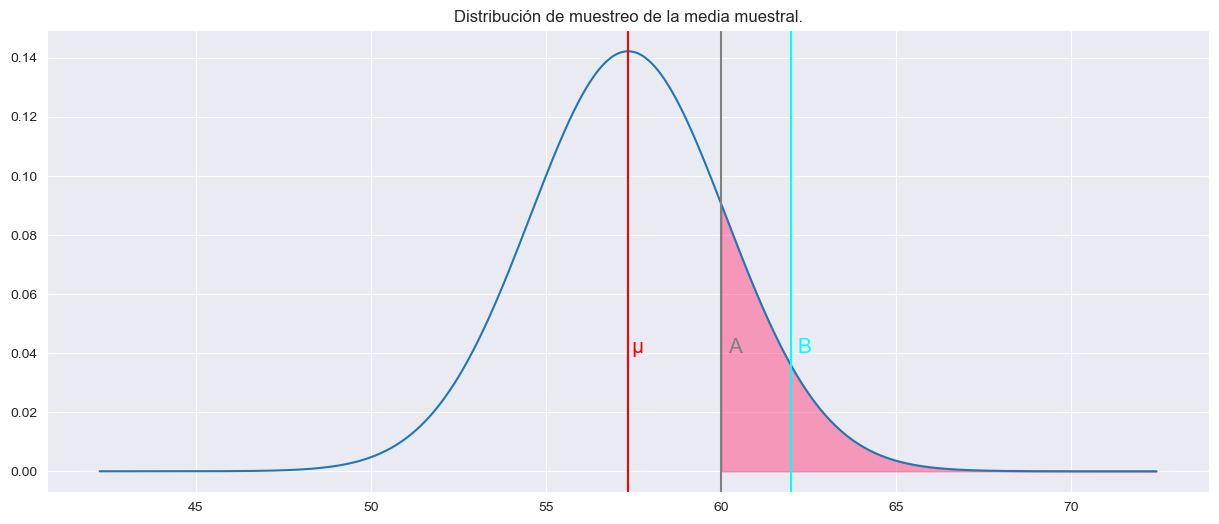

In [22]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
plt.axvline(x = censo['HT'].mean(), color = "red")
plt.axvline(x = 60, color = "grey")
plt.axvline(x = 62, color = "cyan")
plt.text(60.2,0.04,"A", fontsize = 15, color = "grey")
plt.text(62.2,0.04,"B", fontsize = 15, color = "cyan")
plt.text(mu+0.1,0.04,"\u03BC", fontsize = 15, color = "red")
##
x_alpha = np.delete(x, np.where(x < 60))
plt.fill_between(
    x_alpha, nct.pdf(x_alpha, df, nc, loc=mu, scale=se), color=[(1, 0.27, 0.5, 0.5)])
plt.title("Distribución de muestreo de la media muestral.")
plt.show()

#### ***4.2***

Complete el espacio en blanco: "Cuanto ________ el $\alpha$, más conservadora será su prueba y, por lo tanto, más difícil será rechazar la hipótesis nula".

**Respuesta.** Mientras *menor* sea $\alpha$, más conservadora será la prueba y, por lo tanto, más difícil será rechazar la hipótesis nula.

Puede pensarlo de esta manera: cuanto menor sea $\alpha$, más lejos estará el valor crítico de $57.35$, lo que reduce las posibilidades de que la media de su muestra caiga más allá del valor crítico. Esto efectivamente hace que la prueba sea más estricta.

---

## ***Comparar  $\alpha$ y el $p$-valor.***

---



Estando ya familiarizado con el significado de los valores $\alpha$ y $p$, tenemos la siguiente regla que permite interpretar resultados de una prueba de hipótesis.
> Si $p$-valor$< \alpha$, rechazar $H_0$ a favor de $H_a$. De lo contrario, no rechace $H_0$.

Para ver gráficamente por qué funciona esta regla, podemos comparar el siguiente gráfico de una prueba $t$ que nos lleva a rechazar el valor nulo:

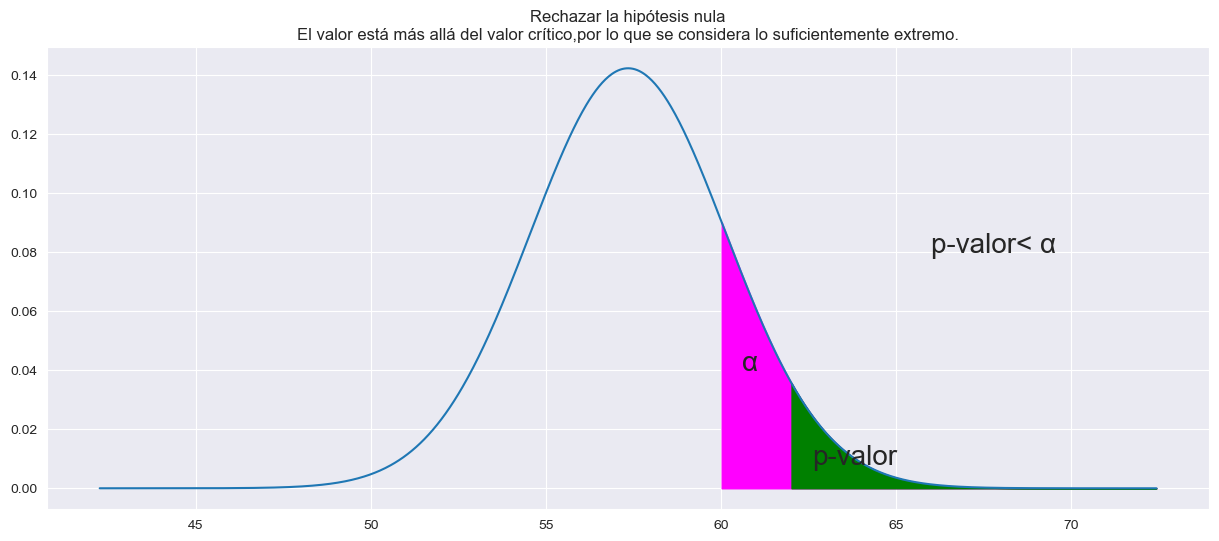

In [23]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
##
x_alpha = np.delete(x, np.where(x < 60))
plt.fill_between(x_alpha, nct.pdf(x_alpha, df, nc, loc=mu, scale=se), color="magenta")
x_pval = np.delete(x, np.where(x < 62))
plt.fill_between(x_pval, nct.pdf(x_pval, df, nc, loc=mu, scale=se), color="green")
plt.title("Rechazar la hipótesis nula\nEl valor está más allá del valor crítico," +
          "por lo que se considera lo suficientemente extremo.")
plt.annotate(text="p-valor", xy=(62.6, 0.008), size=20)
plt.annotate(text="α", xy=(60.6, 0.04), size=20)
plt.annotate(text="p-valor< α", xy=(66, 0.08), size=20)
plt.show()

con una prueba que NO nos permite rechazarla:



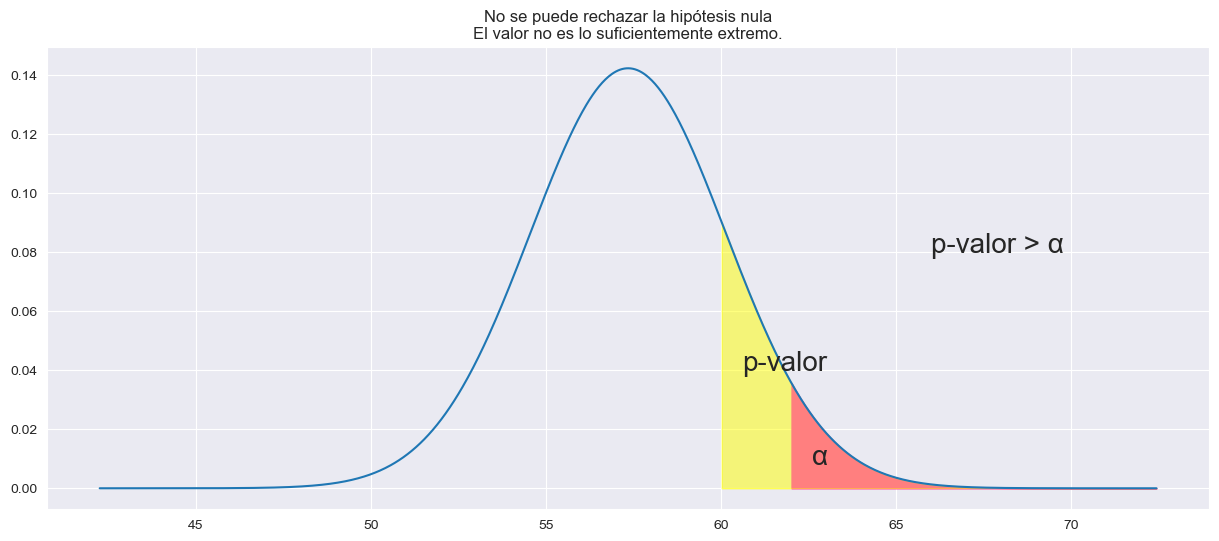

In [24]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
##
x_alpha = np.delete(x, np.where(x < 62))
plt.fill_between(x_alpha, nct.pdf(x_alpha, df, nc, loc=mu, scale=se), color= "magenta")
x_pval = np.delete(x, np.where(x < 60))
plt.fill_between(x_pval, nct.pdf(x_pval, df, nc, loc=mu, scale=se), color=[(1, 1, 0, 0.5)])
plt.title("No se puede rechazar la hipótesis nula\nEl valor no es lo suficientemente extremo.")
plt.annotate(text="α", xy=(62.6, 0.008), size=20)
plt.annotate(text="p-valor", xy=(60.6, 0.04), size=20)
plt.annotate(text="p-valor > α", xy=(66, 0.08), size=20)
plt.show()

***Por lo tanto, siempre tenga en cuenta que un $p$-valor menor que su nivel de significancia puede rechazar la hipótesis nula.***

#### ***Pregunta.***

Suponga que realizó una prueba $t$ - con un nivel de significancia de $\alpha=0.01$. El $p$-valor resultante fue 0,02. ¿Rechaza la hipótesis nula o no la rechaza?

---

## ***Cambiando de frente.*** <font/>

---



Hasta acá, se ha trabajado en los casos donde la media muestral es mayor que la media poblacional. Vamos a construir una prueba $t$ (prueba para la hipótesis alternativa opuesta) de la forma $H_a: \mu_1 < 57.35$. 

El razonamiento es similar que el anterior, cambiando solo que el $p$-valor será definido como la probabilidad de obtener un valor *menor* o igual a $\bar{X}$. El valor crítico se desplazaría entonces hacia la otra cola de la distribución:

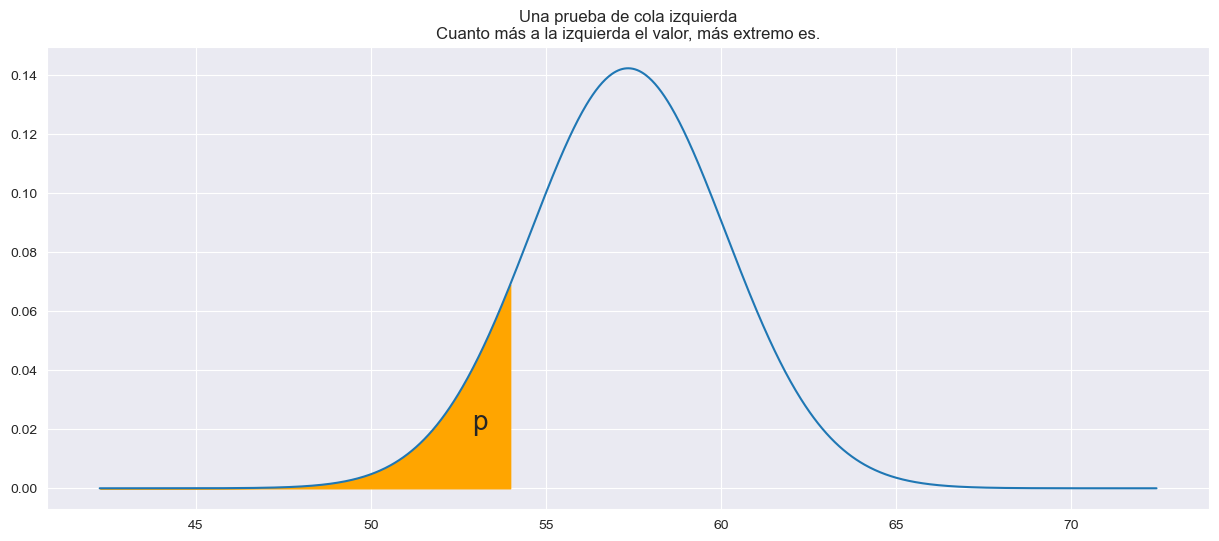

In [25]:
plt.figure(figsize = (15,6))
sns.lineplot(x = x, y = pdf)
##
x_pval = np.delete(x, np.where(x > 54))
plt.fill_between(x_pval, nct.pdf(x_pval, df, nc, loc=mu, scale=se), color= "orange")
plt.title("Una prueba de cola izquierda\nCuanto más a la izquierda el valor, más extremo es.")
plt.annotate(text="p", xy=(52.9, 0.02), size=20)
plt.show()

Finalmente, se puede tener una prueba $t$ a dos colas. En este caso, la hipótesis alternativa sería que $\mu_1$ es mayor *o* menor que $\mu$, es decir, $H_a: \mu_1 \neq \mu$ y por lo tanto su $\alpha$ se dividiría entre las dos colas:

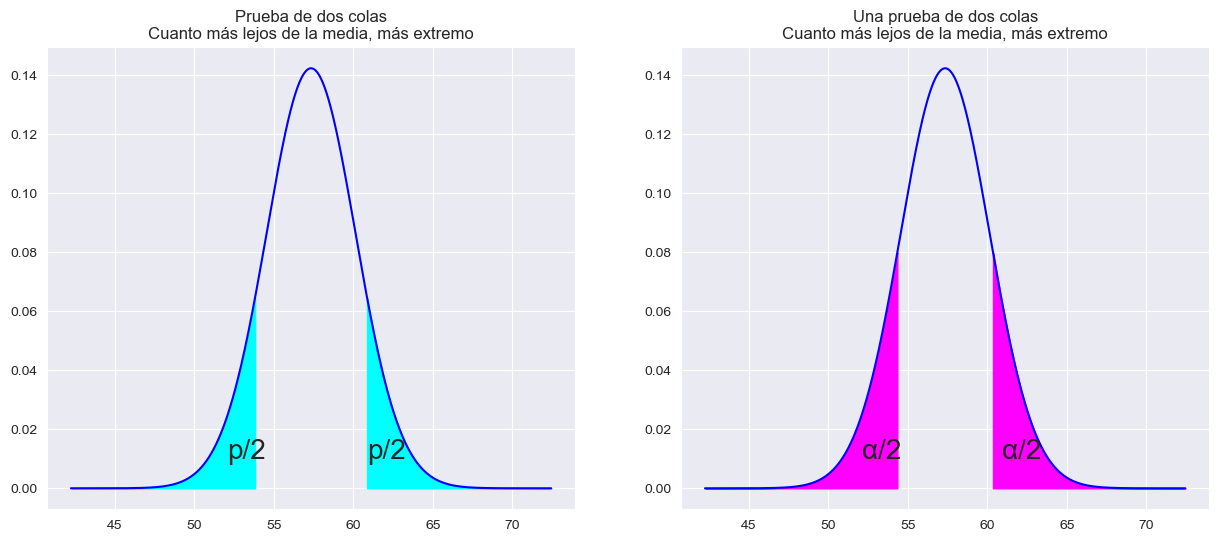

In [26]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(x, nct.pdf(x, df, nc, loc=mu, scale=se), label="nct pdf", color="blue")
ax[0].set_title("Prueba de dos colas\nCuanto más lejos de la media, más extremo")
x_pval_left = np.delete(x, np.where(x > (mu - 3.5)))
ax[0].fill_between(x_pval_left, nct.pdf(x_pval_left, df, nc, loc=mu, scale=se), color= "cyan")
x_pval_right = np.delete(x, np.where(x < (mu + 3.5)))
ax[0].fill_between(x_pval_right,nct.pdf(x_pval_right, df, nc, loc=mu, scale=se),color="cyan")
ax[0].annotate(text="p/2", xy=(52.1, 0.01), size=20)
ax[0].annotate(text="p/2", xy=(60.9, 0.01), size=20)
ax[1].plot(x, nct.pdf(x, df, nc, loc=mu, scale=se), label="nct pdf", color="blue")
ax[1].set_title("Una prueba de dos colas\nCuanto más lejos de la media, más extremo")
x_alpha_left = np.delete(x, np.where(x > (mu - 3.0)))
ax[1].fill_between(x_alpha_left,nct.pdf(x_alpha_left, df, nc, loc=mu, scale=se),color="magenta")
x_alpha_right = np.delete(x, np.where(x < (mu + 3.0)))
ax[1].fill_between(x_alpha_right,nct.pdf(x_alpha_right, df, nc, loc=mu, scale=se),
                   color= "magenta")
ax[1].annotate(text="α/2", xy=(52.1, 0.01), size=20)
ax[1].annotate(text="α/2", xy=(60.9, 0.01), size=20)
plt.show()

Luego, si una prueba $t$ de una cola tuviera un $\alpha$ de 0.05, en la versión de dos colas todavía tendría un $\alpha$ total de 0.05. Si la media de la muestra $\bar{X}$ cae más allá de *cualquiera* de los dos valores críticos (uno a la izquierda y otro a la derecha), entonces la prueba indicará que se debe rechazar la hipótesis nula.

---

##  ***Encuesta de los árboles en el bosque del problema.*** </font>

---



Ahora que hemos explorado la situación detrás de las pruebas $t$, seguimos con el problema de negocios inicial. Ahora debe ser mucho más fácil de solucionar.

A continuación tenemos una muestra de la encuesta que realizó el equipo en el bosque protegido de California:

In [27]:
## df:DataFrame donde tenemos la encuesta.
df = pd.read_csv(url_base + "forest_survey.csv",header = 0,
                 names=["CN", "HT","SITREE","common_name","scientific_name"],)
df.head()

,CN,HT,SITREE,common_name,scientific_name
208659,15458334010497,90.0,52.0,white fir,Abies concolor
203043,15375836010497,44.0,50.0,white fir,Abies concolor
201091,15384570010497,37.0,45.0,white fir,Abies concolor
195762,15337555010497,120.0,85.0,white fir,Abies concolor
199488,15358775010497,53.0,60.0,white fir,Abies concolor


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 208659 to 195187
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CN               1800 non-null   int64  
 1   HT               1800 non-null   float64
 2   SITREE           1800 non-null   float64
 3   common_name      1800 non-null   object 
 4   scientific_name  1800 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 84.4+ KB


In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CN,1800.0,1.566410e+13,3.228937e+12,1.528944e+13,1.531422e+13,1.533959e+13,1.536493e+13,4.871730e+13
HT,1800.0,5.641056e+01,3.765095e+01,6.000000e+00,2.875000e+01,4.400000e+01,7.700000e+01,2.950000e+02
SITREE,1800.0,6.872722e+01,2.658008e+01,1.700000e+01,5.100000e+01,6.500000e+01,8.600000e+01,1.600000e+02


In [30]:
df['common_name'].unique(), len(df['common_name'].unique())

(array(['white fir', 'California red fir', 'Shasta red fir',
        'Pacific madrone', 'incense-cedar', 'tanoak', 'whitebark pine',
        'lodgepole pine', 'Jeffrey pine', 'sugar pine',
        'western white pine', 'ponderosa pine', 'Douglas-fir',
        'canyon live oak', 'blue oak', 'California black oak',
        'interior live oak', 'redwood'], dtype=object),
 18)

Para este problema usaremos la métrica [*site index*](https://en.wikipedia.org/wiki/Site_index) (`SITREE`), que es la altura del árbol corregida por la edad (entre más antiguo el árbol se tiene mayor altura). Podemos considerar la altura normalizada por edad en pies de una especie determinada en un lugar particular. Por lo general, varía entre ubicaciones según las condiciones del suelo, el clima, el grado de intervención humana, etc. Queremos comparar nuestros índices de sitios forestales con los índices de sitios promedio conocidos en California para 18 especies.

Vamos a realizar múltiples pruebas $t$, una prueba por cada especie. Vamos a contrastar las hipótesis:

* $H_0 : \mu_{forest} = \mu_{california}$
* $H_a : \mu_{forest} \neq \mu_{california}$

donde $\mu_{forest}$ es la media poblacional desconocida de los árboles del bosque según se deduce de la media muestral, y $\mu_{california}$ es la media poblacional conocida de los árboles en todo el estado de California (esta media se calcula utilizando la base de datos de la encuesta Forest Inventory and Analysis). Por supuesto, $\mu_{california}$ varía según la especie. La idea es que si terminamos rechazando la hipótesis nula, entonces este árbol en particular tiene características ecológicas que son diferentes a las del resto del estado de California, y que estas características pueden estar detrás de las diferencias en el crecimiento de especies particulares.

In [31]:
## df_means_population: DataFrame con las medias poblacionales.
df_means_population = pd.read_csv(url_base + "means_california.csv")
df_means_population

,scientific_name,SITREE
0,Abies concolor,57.033584
1,Abies magnifica,54.538569
2,Abies shastensis,44.733624
3,Arbutus menziesii,86.983146
4,Calocedrus decurrens,57.785317
5,Lithocarpus densiflorus,90.304746
6,Pinus albicaulis,32.176101
7,Pinus contorta,57.264946
8,Pinus jeffreyi,59.114140
9,Pinus lambertiana,58.484076


Tenemos las medias de la muestra por cada especie.

In [32]:
## df_means_sample: DataFrame con las medias de las especies en la encuesta.
df_means_sample = df.groupby(["scientific_name"], as_index = False)["SITREE"].mean()
df_means_sample

,scientific_name,SITREE
0,Abies concolor,55.88
1,Abies magnifica,53.80
2,Abies shastensis,45.83
3,Arbutus menziesii,86.09
4,Calocedrus decurrens,58.94
5,Lithocarpus densiflorus,87.39
6,Pinus albicaulis,32.38
7,Pinus contorta,56.97
8,Pinus jeffreyi,57.70
9,Pinus lambertiana,59.68


In [33]:
## DataFrame con las medias poblaciones y las de la encuenta.
df_means_population.merge(df_means_sample, on="scientific_name", 
                          suffixes=("_population","_sample"))

,scientific_name,SITREE_population,SITREE_sample
0,Abies concolor,57.033584,55.88
1,Abies magnifica,54.538569,53.80
2,Abies shastensis,44.733624,45.83
3,Arbutus menziesii,86.983146,86.09
4,Calocedrus decurrens,57.785317,58.94
5,Lithocarpus densiflorus,90.304746,87.39
6,Pinus albicaulis,32.176101,32.38
7,Pinus contorta,57.264946,56.97
8,Pinus jeffreyi,59.114140,57.70
9,Pinus lambertiana,58.484076,59.68


***Realización de una prueba de hipótesis:***

El estadístico de prueba es en este caso:

$$t=\frac{\bar{x}-\mu_{california}}{s/\sqrt n}$$

Y el correspondiente $p$-valor, es:

$$p\text{ -valor} = 2P(t_{n-1}\leq t)$$

In [34]:
## datos del árbol "Abies concolor" en la encuesta (muestra!!! OJO... PUES...).
x = df.loc[df["scientific_name"]== "Abies concolor","SITREE"] 
x

208659    52.0
203043    50.0
201091    45.0
195762    85.0
199488    60.0
          ... 
198418    69.0
201107    45.0
205119    56.0
203896    87.0
198423    69.0
Name: SITREE, Length: 100, dtype: float64

In [35]:
x_barra, s, n = x.mean(),x.std(), len(x) ## media,desviación y tamaño de muestra
                                         ## datos del árbol "Abies concolor" en la encuesta.
(x_barra,s, n)

(55.88, 13.015360001152331, 100)

In [36]:
## Suponemos la hipótesis nula verdadera.
mu_california = df_means_population['SITREE'][0]
mu_california

57.03358373840035

In [37]:
## Estadístico de prueba t.
t_value = (x_barra-mu_california)/(s/np.sqrt(n))
t_value

-0.8863248794487559

In [38]:
## p-valor correspondiente
p_valor = 2*t.cdf(t_value,n-1)
print("El p-valor para la prueba es: {:.4f}".format(p_valor))

El p-valor para la prueba es: 0.3776


Considerando $\alpha = 0.05$, observamos que ***no encontramos diferencias significativas entre la media de la encuesta y la media poblacional*** para la especie de arból ***Abies concolor***. 

In [39]:
## Caso t no central
p_valor_no_central = 2*nct.cdf(x_barra,n-1, 0, loc = mu_california, scale = s/np.sqrt(100))
print("El p-valor para la prueba es: {:.4f}".format(p_valor_no_central))

El p-valor para la prueba es: 0.3776


Nuevamente **NO** rechazamos $H_{0}$.

### Con la ayuda de `Python`.

Vamos a hacer uso de [`pingouin.ttest`](https://pingouin-stats.org/generated/pingouin.ttest.html) para realizar la misma prueba anterior

In [40]:
ttest(x,mu_california).iloc[:,0:5]

,T,dof,alternative,p-val,CI95%
T-test,-0.886325,99,two-sided,0.37759,"[53.3, 58.46]"


#### ***Ejercicio 5.***

Realice todas las pruebas $t$ (una por cada especie). ¿Qué especies muestran una diferencia estadísticamente significativa a un nivel de significancia de 0.05?

In [41]:
df_means_sample['scientific_name']

0              Abies concolor
1             Abies magnifica
2            Abies shastensis
3           Arbutus menziesii
4        Calocedrus decurrens
5     Lithocarpus densiflorus
6            Pinus albicaulis
7              Pinus contorta
8              Pinus jeffreyi
9           Pinus lambertiana
10            Pinus monticola
11            Pinus ponderosa
12      Pseudotsuga menziesii
13        Quercus chrysolepis
14          Quercus douglasii
15          Quercus kelloggii
16          Quercus wislizeni
17       Sequoia sempervirens
Name: scientific_name, dtype: object

In [42]:
df_fin = pd.DataFrame()
##
for i,tree in enumerate(df_means_sample['scientific_name']):
  x = df.loc[df["scientific_name"]== tree,"SITREE"]
  y = ttest(x,df_means_population["SITREE"][i]).iloc[:,0:5].rename(index={"T-test":tree})
  df_fin = df_fin.append(y)
  
df_fin

/tmp/ipykernel_7718/2884388718.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fin = df_fin.append(y)
/tmp/ipykernel_7718/2884388718.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fin = df_fin.append(y)
/tmp/ipykernel_7718/2884388718.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fin = df_fin.append(y)
/tmp/ipykernel_7718/2884388718.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fin = df_fin.append(y)
/tmp/ipykernel_7718/2884388718.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fin = df_fin.append(y)
/tmp/ipyke

,T,dof,alternative,p-val,CI95%
Abies concolor,-0.886325,99,two-sided,0.377590,"[53.3, 58.46]"
Abies magnifica,-0.354963,99,two-sided,0.723373,"[49.67, 57.93]"
Abies shastensis,1.045444,99,two-sided,0.298364,"[43.75, 47.91]"
Arbutus menziesii,-0.369082,99,two-sided,0.712855,"[81.29, 90.89]"
Calocedrus decurrens,0.767267,99,two-sided,0.444749,"[55.95, 61.93]"
Lithocarpus densiflorus,-1.356956,99,two-sided,0.177881,"[83.13, 91.65]"
Pinus albicaulis,0.136974,99,two-sided,0.891329,"[29.43, 35.33]"
Pinus contorta,-0.216861,99,two-sided,0.828763,"[54.27, 59.67]"
Pinus jeffreyi,-0.742768,99,two-sided,0.459381,"[53.92, 61.48]"
Pinus lambertiana,0.666820,99,two-sided,0.506438,"[56.12, 63.24]"


In [43]:
df_fin.loc[df_fin["p-val"]<0.05]

,T,dof,alternative,p-val,CI95%
Sequoia sempervirens,-2.566003,99,two-sided,0.011786,"[90.97, 100.01]"


Si observa detenidamente, el $p$-valor para *Sequoia sempervirens* es pequeño. Sin embargo, la media muestral para esta especie en este bosque es $\bar{X}=95,49 \text{ ft}$, mientras que la media en todo California es $\mu_{california}=101,33 \text{ ft}$. Esta diferencia es ligeramente mayor de 5 pies, lo que no parece mucho dado que las secuoyas se encuentran entre los árboles más altos del mundo.

## ***Conclusiones:***
---


Resumiendo:

1. Se explicó el concepto de prueba de hipótesis. Esta herramienta que ayudará con problemas que involucran la detección de diferencias entre poblaciones.

2. Comprendió la importancia de reconocer cuándo los cambios en nuestros datos representan una variabilidad normal o no, y cómo la prueba de hipótesis puede ayudarnos con este problema.

3. Aprendió a interpretar el resultado de una prueba de hipótesis usando los $p$-valores en el contexto de distribuciones muestrales y sus aproximaciones con la distribución $t$. El concepto de valores $p$ aparece en muchos modelos que se utilizan en la ciencia de datos y también los veremos en varios casos futuros.

## ***Créditos:***
---

"Giant sequoias in Sequoia National Park 02 2013", Sep 15, 2013, Tuxyso (Wikimedia Commons), CC BY-SA 3.0, https://commons.wikimedia.org/wiki/File:Giant_sequoias_in_Sequoia_National_Park_02_2013.jpg

"FIA Datamart", 2021, U.S. Department of Agriculture, Forest Service, [Public Domain](https://www.usda.gov/policies-and-links), https://apps.fs.usda.gov/fia/datamart/CSV/datamart_csv.html.